# Load main libraries

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import sys
import string
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set() # use seaborn for better plots


"""
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
"""

#---this can be used for craeting zoomable matplotlib plots.
#---but it makes the notebook handling slow (e.g. not so smooth scroll)
#import mpld3
#mpld3.enable_notebook()

#%matplotlib inline
# ---------------------------------

"\nSMALL_SIZE = 10\nMEDIUM_SIZE = 12\nBIGGER_SIZE = 16\n\nplt.rc('font', size=SMALL_SIZE)          # controls default text sizes\nplt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title\nplt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels\nplt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\nplt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels\nplt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize\nplt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title\n"

# Equispaced time series
This function converts an irregular time series (i.e. variable time stepping) to equispaced regular time series

In [2]:
def equispaced_time(in_time, out_time, signal):
    equi_out_time = np.linspace(out_time[0], out_time[-1], len(out_time))
    out_data = np.interp(equi_out_time, in_time, signal)
    return out_data

# Load data
Here we read the data. 

If a .csv data file is present, then it reads it directly. 

Else, it reads the dipole.tag files produced by the MagIC code.

**Equispaced and standardized (mean 0) time series is produced by default.**

**The start time of the time series is forced to 0 by default.**

In [3]:
os.chdir('/home/ryadav/Meduri_reversals/dipole_files')

fname = 'Time_DipTilt_Dipl11_equispaced_standardized.csv'

if os.path.isfile(fname):
    df = pd.read_csv(fname)
    print('Read file', fname)
else:
    atoz = string.ascii_lowercase
    tags = ['BM+Ra5e5'+letter+str(integer) for integer in [5, 6, 7] for letter in atoz]

    num_files = -1
    standard = True

    tags = tags[0:num_files]
    
    #read dipole.tag files, a bit messy since data is in fortran 'D' notation
    for ind, item in enumerate(tags):
        print(ind, item)
        fname = 'dipole.'+item
        f = open(fname, 'r')
        X = []
        for k, line in enumerate(f.readlines()):
            st = line.replace('D', 'e')
            X.append(st.split())
        X = np.asarray(X, dtype=float)
        f.close()

        time = np.linspace(X[0,0], X[-1,0], X.shape[0])
        # dipole tilt angle wrt tothe rotation axis
        dip_tilt = equispaced_time(X[:,0], X[:,0], X[:,1])
        # convert from [0,180] to [90,-90]
        dip_tilt += -90 
        # l=1 (axial dipole) strength compared to l up to 11
        dip_l11 = equispaced_time(X[:,0], X[:,0], X[:,5]) 

        if ind==0:
            df  = pd.DataFrame({'time':time, 'dipole_tilt':dip_tilt, 'dip_l11':dip_l11}, dtype=np.float32)
        else:
            df2 = pd.DataFrame({'time':time, 'dipole_tilt':dip_tilt, 'dip_l11':dip_l11}, dtype=np.float32)

            df = df.append(df2, ignore_index=True)

    # rescale time to -> 0 -- t
    df['time'] = df['time']-df['time'].min() 

    # perform standardization 
    if standard==True:
        from sklearn.preprocessing import StandardScaler
        scaled_features = StandardScaler().fit_transform(df[['dipole_tilt', 'dip_l11']].values)
        #print(scaled_features.shape)
        df['dipole_tilt'] = scaled_features[:,0]
        df['dip_l11'] = scaled_features[:,1]

Read file Time_DipTilt_Dipl11_equispaced_standardized.csv


OPTIONAL: can be used for storing data to csv is read from dipole.tag files in the above section

In [4]:
# for saving data
#df[['time','dipole_tilt']].to_csv('Time_DipTilt_equispaced_standardized.csv', index=False)
#df.to_csv('Time_DipTilt_Dipl11_equispaced_standardized.csv', index=False)

# Plot a small section of the data

(5764077, 3)


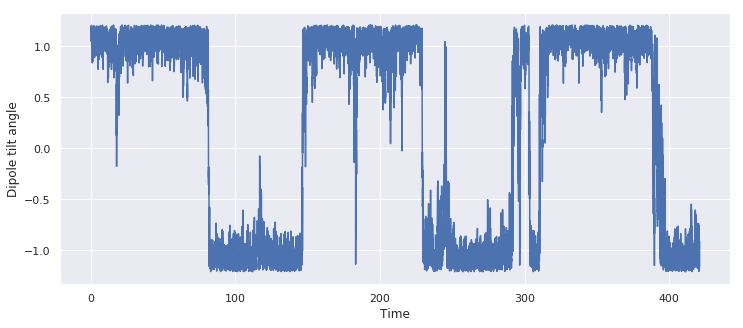

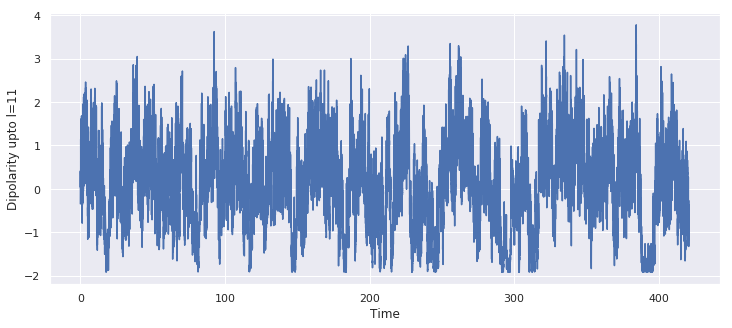

In [5]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['time'][0:70000], df['dipole_tilt'][0:70000])
plt.xlabel('Time')
plt.ylabel('Dipole tilt angle')

fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['time'][0:70000], df['dip_l11'][0:70000])
plt.xlabel('Time')
plt.ylabel('Dipolarity upto l=11')


print(df.shape)

# FFT based smoothing function
Takes a dataframe as input and the strength of the smoothing required.

In [34]:
def smooth_data(df_main, low_pass_strength=1):

    # low pass filter the data
    from scipy.signal import butter, filtfilt, freqz

    def butter_lowpass(cutoff, fs, order=3):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=3):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        return y


    order = 6
    fs = 10.0  # sample rate
    # severity of the smoothing, higher val, higher smoothing
    cutoff = 1/(low_pass_strength+1.0) 

    df_smooth = pd.DataFrame(index=df_main.index,columns=df_main.columns)

    df_smooth['time'] = butter_lowpass_filter(df_main['time'].values, cutoff, fs, order)
    df_smooth['dipole_tilt'] = butter_lowpass_filter(df_main['dipole_tilt'].values, cutoff, fs, order)
    df_smooth['dip_l11'] = butter_lowpass_filter(df_main['dip_l11'].values, cutoff, fs, order)    
    
    fig, ax = plt.subplots(figsize=(12,5))
    plt.plot(df_main['time'], df_main['dipole_tilt'], 'r.', label='Original')
    plt.plot(df_main['time'].values, df_main['dipole_tilt'].values, 'r-')
    plt.plot(df_smooth['time'], df_smooth['dipole_tilt'], 'b.', label='Smoothed')
    plt.plot(df_smooth['time'].values, df_smooth['dipole_tilt'].values, 'b-')
    plt.xlabel('Time')
    plt.ylabel('Dipole tilt angle')
    plt.legend()
    plt.xlim([200,200.5])
    plt.ylim([0.5,1.5])
    
    return df_smooth


# Function to increase the time resolution of a series
Takes a data frame and the factor by which to increase the time resolution

In [35]:
# use interpolation to increase time resulutio
# may be useful for capturing rapid equator crossings
def increase_time_res(df_main, factor=2):
    
    df_out = pd.DataFrame(np.nan, 
                          index = np.arange(df_main.shape[0]*factor), 
                          columns = df_main.columns,
                          dtype=np.float32)
    
    df_out['time'] = np.linspace(df_main['time'].values[0], df_main['time'].values[-1], df_out.shape[0])
    df_out['dipole_tilt'] = equispaced_time(df_main['time'].values, df_out['time'].values, df_main['dipole_tilt'].values)
    df_out['dip_l11'] = equispaced_time(df_main['time'].values, df_out['time'].values, df_main['dip_l11'].values)
    
    #print(df_main['time'].values[0])
    return df_out


# Get and classify the zero (i.e. equator) crossings
Extract and then classify zero (or 'equator' in geodynamo terminology) crossings as reversals and excursions. A Reversal event (labelled '1') is when the time series suddenly goes from +ve to -ve (or vice versa) values. An Excursion event (labelled '0') is when it fails to change sign and comes back to being +ve or -ve.

We extract equator crossing by checking if dipole_tilt[i] * dipole_tilt[i+1] is -ve or not. 

The **pad_size** (in number of points) defines a narrow window of time centered around the Reversal/Excursion event. An event will be defined by the quality and nature of data in this window.

Since the time series is chaotic, some of the events can be very messy. The function uses the standard deviation of series in the left and right padding to define how messy the time series is. We can use a threshold **std_thres** value to pick cleaner events.

The function adds *nature*, *left_std* and *right_std* columns to the input data frame.

An even is 1 (Reversal) if the means of left and right padding series are opposite, and 0 otherwise.

In [36]:
def get_EqCros(df_main, pad_size=1500, std_thres=0.2):
    
    # get equator crossing times, check 2 points if i is -ve and i+1 is +ve
    # looping over the df is very slow, so construct shifted dataframes 
    df_i = df_main.iloc[0:-1] # first to second last point
    df_iplus1 = df_main.iloc[1:]# second to last point
    
    # multiply i and i+1 values to check -ve values which indicate equator crossing
    df_mul = pd.DataFrame(df_i.values*df_iplus1.values, columns=df_i.columns, index=df_i.index)
    
    df_EquCross  = df_main.loc[df_mul[df_mul['dipole_tilt']<0].index]
    
    # Clean df_EquCross to remove very close data points.
    # First get the indices to drop from the df
    drop_indices=[]
    for i in range(df_EquCross.shape[0]-1):
        #check following 5 points for proximity
        for j in range(5):
            if i+j+1 < df_EquCross.shape[0]: # avoid issue at the end point of df_EquCross
                if df_EquCross.index[i+j+1] - df_EquCross.index[i] < pad_size:
                    drop_indices.append(df_EquCross.index[i+j+1])

    df_EquCross.drop(drop_indices, inplace=True)
    #print(df_EquCross.shape)
    
    # Add new columns containing the nature and standard deviation of dipole 
    # tilt in the left and right paddings of the equator crossing times
    df_EquCross['nature'] = pd.Series(np.zeros(df_EquCross.shape[0]), 
                                      index=df_EquCross.index, 
                                      dtype=int)
    df_EquCross['left_std'] = pd.Series(np.zeros(df_EquCross.shape[0]), 
                                      index=df_EquCross.index, 
                                      dtype=float)
    df_EquCross['right_std'] = pd.Series(np.zeros(df_EquCross.shape[0]), 
                                      index=df_EquCross.index, 
                                      dtype=float)
    
    # get nature of equtor crossings
    for i in range(df_EquCross.shape[0]): 
        LeftInds = [df_EquCross.index[i]-j for j in range(pad_size)]
        LeftSum = df_main.iloc[LeftInds]['dipole_tilt'].sum()/pad_size
        # access elements by '.at' function -> df.at[index, column]
        df_EquCross.at[df_EquCross.index[i], 'left_std'] = df_main.iloc[LeftInds]['dipole_tilt'].std()

        # Summing on the right hand side padding may cause issues if the last 
        # equator crossing is being considered.
        # So, shrink the padding size equal to the no. of last available points
        # at the end of the series
        if i == df_EquCross.shape[0] - 1: # basically, last iteration
            pad_size_temp = df_main.index[-1] - df_EquCross.index[i]
        else:
            pad_size_temp = pad_size

        RightInds = [df_EquCross.index[i]+j for j in range(pad_size_temp)]
        RightSum = df_main.iloc[RightInds]['dipole_tilt'].sum()/pad_size_temp
        df_EquCross.at[df_EquCross.index[i], 'right_std'] = df_main.iloc[RightInds]['dipole_tilt'].std()

        if LeftSum*RightSum > 0:
            # access elements by '.at' function -> df.at[index, column]
            df_EquCross.at[df_EquCross.index[i], 'nature'] = 0
        else:
            df_EquCross.at[df_EquCross.index[i], 'nature'] = 1

    # use std threshold for selecting cleaner reversals/excursions
    cond2 = (df_EquCross['left_std']<std_thres) & (df_EquCross['right_std']<std_thres)
    df_EquCross_clean = df_EquCross[cond2]
    
    return df_EquCross_clean

#get_EqCros(df)

# Cook data for machine learning
Prepare data as a series of events which will be fed to ML functions. 

output -> (num of events, pad_size, num of features), (labels)

We have left and right paddings around an event. We call the left padding as one data point. 


In [37]:
def cook_data(df_main, df_EqCros, pad_size=1500):
    X_data = []
    y_data = []
    for i in range(df_EqCros.shape[0]-1): # Skipping the last data point.
                                          # Right padding may be smaller than pad size
        
        LeftInds = [df_EqCros.index[i]-pad_size+j for j in range(pad_size)]
        # convert South latitudes to North for consistent dataset
        if df_main.iloc[LeftInds]['dipole_tilt'].mean()<0:
            X_data.append(  [-1.0*df_main.iloc[LeftInds]['dipole_tilt'], 
                                  df_main.iloc[LeftInds]['dip_l11'    ]  ] )
        else:
            X_data.append(  [     df_main.iloc[LeftInds]['dipole_tilt'], 
                                  df_main.iloc[LeftInds]['dip_l11'    ]  ] )
        y_data.append(df_EqCros.iloc[i]['nature'])
    return np.array(X_data), np.array(y_data)


# Perform the calculations using the functions above

Data has been smoothed.
Time resolution has been increased by a factor of 2
Add data from reverse pass.
X train=(363, 2, 2000), Y train=(363,).
X test=(91, 2, 2000), Y test=(91,)


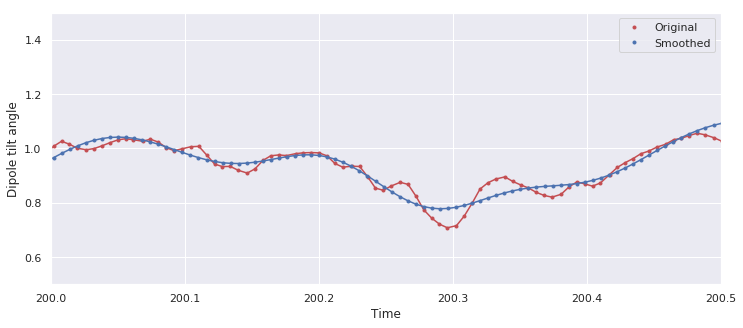

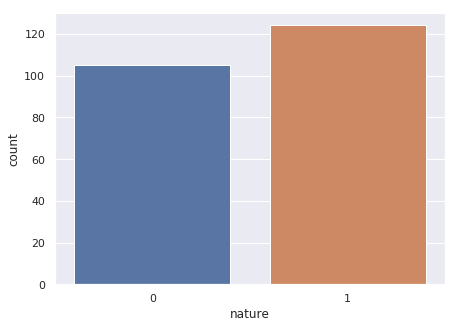

In [38]:
from sklearn.model_selection import train_test_split

# padding size (in no. of points) of the analysis window around the equator crossings
pad_size = 1000
std_thres = 0.3 # North hemi has about 0 to 1 normalized latitude range
smooth = True
reverse =True

increase_res, factor = True, 2
if increase_res==True:
    pad_size = factor*pad_size 
    

df_main = df

# get the data
if smooth==True: 
    df_main = smooth_data(df, low_pass_strength=1) # will produce a plot as well
    print('Data has been smoothed.')
    
# increase time series resolution using interpolation
if increase_res == True:
    df_main = increase_time_res(df_main, factor=factor)
    print('Time resolution has been increased by a factor of', factor)

# get where reversal/excursions happened
df_EquCross_forward = get_EqCros(df_main, pad_size=pad_size, std_thres=std_thres)

# plot number of reversals/excursions
fig, ax = plt.subplots(figsize=(7,5))
sns.countplot(df_EquCross_forward['nature'])

# prepare data for LSTM
X, y = cook_data(df_main, df_EquCross_forward, pad_size=pad_size)

if reverse ==True:
    # do a reverse pass to get more data and append to the forward pass data
    print('Add data from reverse pass.')
    df_main_reverse = pd.DataFrame(df_main.values[::-1,::], columns=df_main.columns, index=df_main.index)
    df_EquCross_reverse = get_EqCros(df_main_reverse, pad_size=pad_size, std_thres=std_thres)
    X_reverse, y_reverse = cook_data(df_main_reverse, df_EquCross_reverse, pad_size=pad_size)
    X, y = np.concatenate( (X, X_reverse) ), np.concatenate( (y, y_reverse) )
    #print(X.shape, y.shape)


# Train test spilling
X_TRAIN, X_TEST, y_TRAIN, y_TEST = train_test_split(X, y, test_size=0.2, shuffle=True)


print('X train={}, Y train={}.'.format(X_TRAIN.shape, y_TRAIN.shape))
print('X test={}, Y test={}'.format(X_TEST.shape, y_TEST.shape))


# Look at some of the extracted events

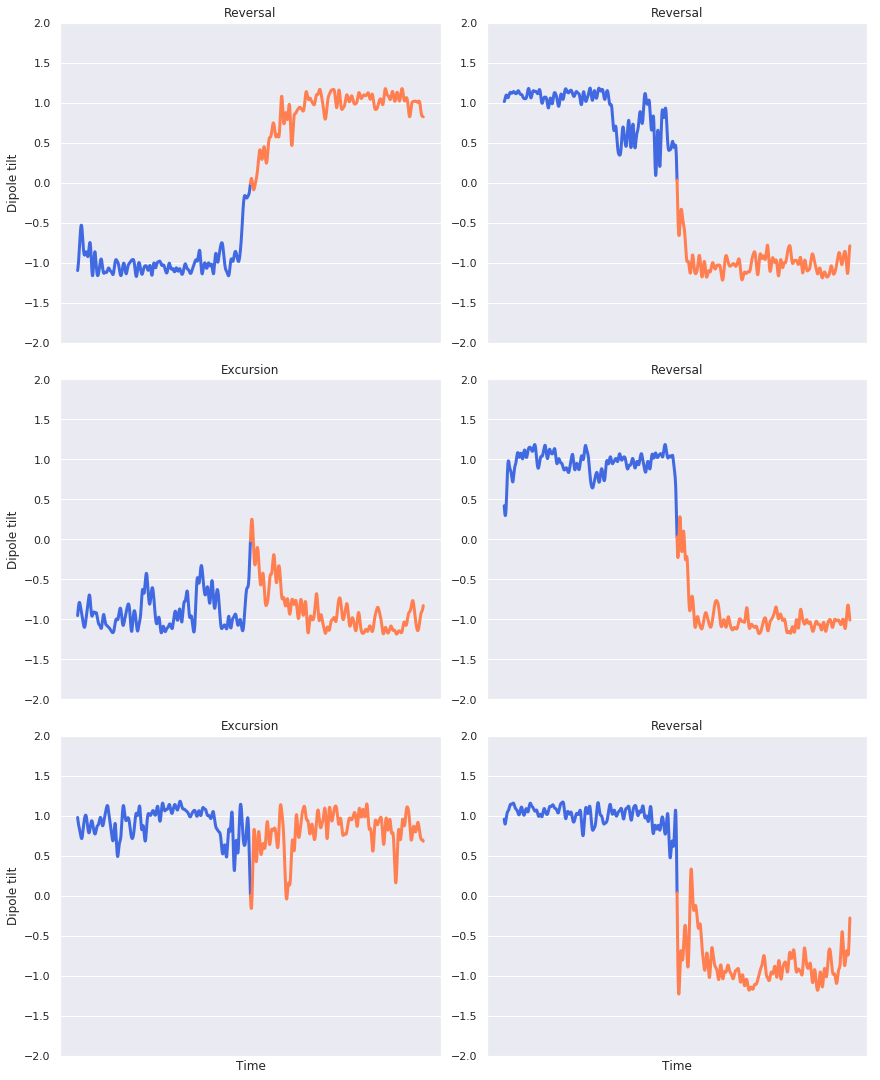

In [39]:
fig_rows=3
fig_cols=2
plot_window_size=pad_size

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(12,15))
fig.tight_layout()

for i in range(fig_rows):
    for j in range(fig_cols):
        rand_ind = np.random.randint(0,df_EquCross_forward.shape[0])
        LeftInds = [df_EquCross_forward.index[rand_ind]-k for k in range(plot_window_size)]
        ax[i,j].plot( df_main.iloc[LeftInds]['dipole_tilt'], '-', color='royalblue', lw=3)
        #ax[i,j].plot( df_main.iloc[LeftInds]['dip_l11'], '-', color='k', lw=1, alpha=0.3)

        RightInds = [df_EquCross_forward.index[rand_ind]+k for k in range(plot_window_size)]
        ax[i,j].plot( df_main.iloc[RightInds]['dipole_tilt'], '-', color='coral', lw=3)
        #ax[i,j].plot( df_main.iloc[RightInds]['dip_l11'], '-', color='k', lw=1, alpha=0.3)
        
        ax[i,j].set_ylim([-2,2])

        if df_EquCross_forward.at[df_EquCross_forward.index[rand_ind], 'nature']==0:
            ax[i,j].set_title('Excursion')
        else:
            ax[i,j].set_title('Reversal')
        #ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].axes.get_xaxis().set_ticks([])
        if j==0:
            ax[i,j].set_ylabel('Dipole tilt')
        if i==fig_rows-1:
            ax[i,j].set_xlabel('Time')
            
plt.show()
#plt.ylabel('Dipole tilt angle')

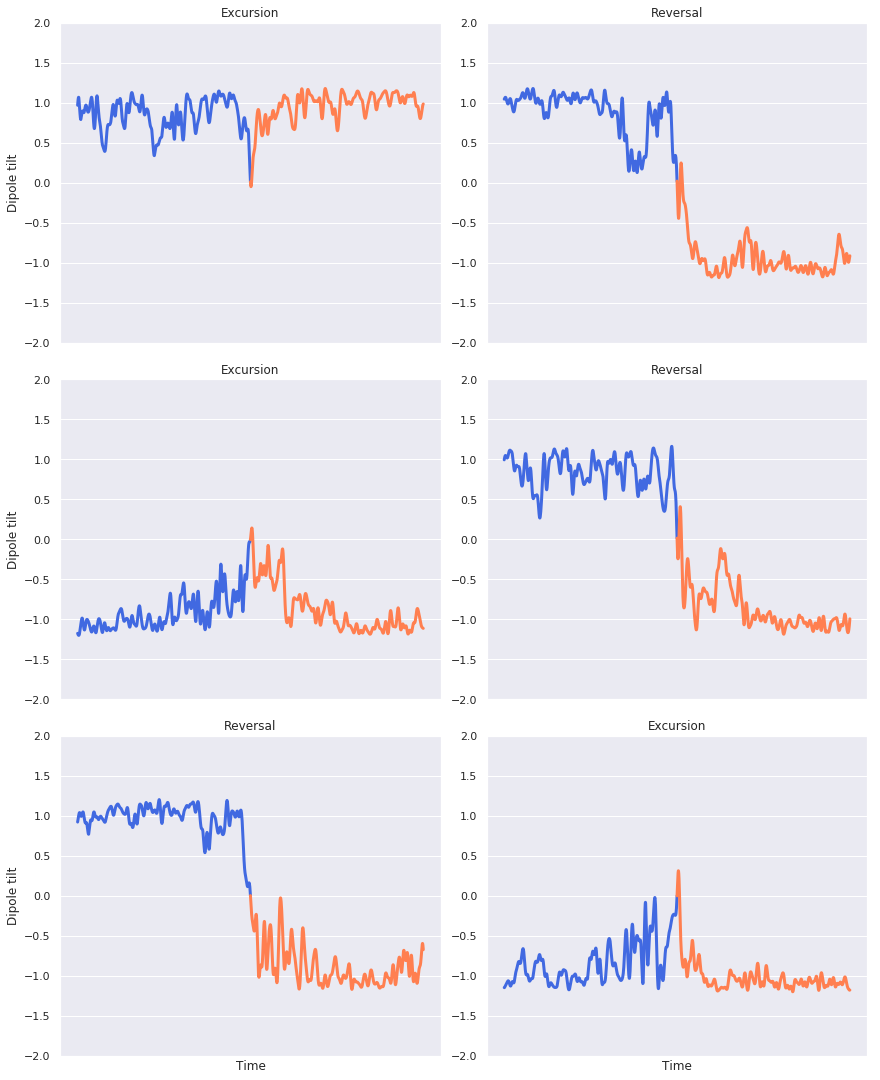

In [41]:
# inspect events from reverse pass

fig_rows=3
fig_cols=2
plot_window_size=pad_size

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(12,15))
fig.tight_layout()

for i in range(fig_rows):
    for j in range(fig_cols):
        rand_ind = np.random.randint(0,df_EquCross_reverse.shape[0])
        LeftInds = [df_EquCross_reverse.index[rand_ind]-k for k in range(plot_window_size)]
        ax[i,j].plot( df_main_reverse.iloc[LeftInds]['dipole_tilt'], '-', color='royalblue', lw=3)

        RightInds = [df_EquCross_reverse.index[rand_ind]+k for k in range(plot_window_size)]
        ax[i,j].plot( df_main_reverse.iloc[RightInds]['dipole_tilt'], '-', color='coral', lw=3)
        
        ax[i,j].set_ylim([-2,2])

        if df_EquCross_reverse.at[df_EquCross_reverse.index[rand_ind], 'nature']==0:
            ax[i,j].set_title('Excursion')
        else:
            ax[i,j].set_title('Reversal')
        #ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].axes.get_xaxis().set_ticks([])
        if j==0:
            ax[i,j].set_ylabel('Dipole tilt')
        if i==fig_rows-1:
            ax[i,j].set_xlabel('Time')
            
plt.show()
#plt.ylabel('Dipole tilt angle')

# some diagnostic plotting functions

In [42]:
# interactively plot dipole tilts of several randomly-chosen reversals and recursions
if False:
    from IPython import display
    import time

    fig, ax = plt.subplots(figsize=(12,5))
    num_points=10
    plot_window_size=pad_size
    for i in np.random.randint(0,df_EquCross.shape[0], num_points):
        LeftInds = [df_EquCross.index[i]-j for j in range(plot_window_size)]
        plt.plot( df_main.iloc[LeftInds]['dipole_tilt'], 'b-')

        RightInds = [df_EquCross.index[i]+j for j in range(plot_window_size)]
        plt.plot( df_main.iloc[RightInds]['dipole_tilt'], 'r-')

        plt.ylim([-90,90])
        if df_EquCross.at[df_EquCross.index[i], 'nature']==0:
            plt.title('Excursion')
        else:
            plt.title('Reversal')
        plt.xlabel('Index')
        plt.ylabel('Dipole tilt angle')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(1.0)
        plt.clf()

# interactively plot LSTM input data for investigation
if False:
    from IPython import display
    import time

    fig, ax = plt.subplots(figsize=(12,5))
    num_points=10
    for i in np.random.randint(0, X_TRAIN.shape[0], num_points):#np.random.randint(0, X_test.shape[0], num_points):
        plt.plot(X_TRAIN[i,0])# dipole tilt
        #plt.plot(X_train[i,1])# l11 dipolarity
        plt.ylim([1.3,-0.05])
        if y_TRAIN[i] == 1:
            plt.title('Reversal')
        else:
            plt.title('Excursion')
        plt.xlabel('Index')
        plt.ylabel('Dipole tilt angle')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(3.0)
        plt.clf()

# Truncate data
large padding is needed for picking out good events but probably not needed for prediction

In [43]:
# X TRAIN -> (instance, features, data)

start_ind, end_ind = 1000, -1
X_TRAIN_trunc, X_TEST_trunc = X_TRAIN[:,:, start_ind:end_ind], X_TEST[:,:, start_ind:end_ind]
print('Truncated input training data shape:', X_TRAIN_trunc.shape, y_TRAIN.shape)

Truncated input training data shape: (363, 2, 999) (363,)


# Apply machine learning to the extracted data


Input training data shape: (363, 999, 1)
Test data shape: (91, 999, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 999, 8)            32        
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 499, 8)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 499, 8)            200       
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 249, 8)            0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 249, 8)            200       
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 124, 8)            0         
_________________________________________________________________
lstm_


Epoch 00034: val_acc did not improve from 0.56044
Epoch 35/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6885 - acc: 0.5427 - val_loss: 0.6856 - val_acc: 0.5604

Epoch 00035: val_acc did not improve from 0.56044
Epoch 36/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6882 - acc: 0.5427 - val_loss: 0.6856 - val_acc: 0.5604

Epoch 00036: val_acc did not improve from 0.56044
Epoch 37/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6880 - acc: 0.5427 - val_loss: 0.6857 - val_acc: 0.5604

Epoch 00037: val_acc did not improve from 0.56044
Epoch 38/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6878 - acc: 0.5427 - val_loss: 0.6860 - val_acc: 0.5604

Epoch 00038: val_acc did not improve from 0.56044
Epoch 39/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6868 - acc: 0.5455 - val_loss: 0.6862 - val_acc: 0.5604

Epoch 00039: val_acc did not improve from 0.56044
Epoch 40/150
363/363 [==

363/363 [==============================] - 1s 3ms/step - loss: 0.6763 - acc: 0.5427 - val_loss: 0.6906 - val_acc: 0.5385

Epoch 00078: val_acc did not improve from 0.59341
Epoch 79/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6746 - acc: 0.5785 - val_loss: 0.6935 - val_acc: 0.5714

Epoch 00079: val_acc did not improve from 0.59341
Epoch 80/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6762 - acc: 0.5537 - val_loss: 0.6945 - val_acc: 0.5824

Epoch 00080: val_acc did not improve from 0.59341
Epoch 81/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6727 - acc: 0.5537 - val_loss: 0.7025 - val_acc: 0.5604

Epoch 00081: val_acc did not improve from 0.59341
Epoch 82/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6708 - acc: 0.5647 - val_loss: 0.7032 - val_acc: 0.5385

Epoch 00082: val_acc did not improve from 0.59341
Epoch 83/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6730 - acc

363/363 [==============================] - 1s 3ms/step - loss: 0.6497 - acc: 0.5895 - val_loss: 0.7206 - val_acc: 0.5934

Epoch 00121: val_acc did not improve from 0.61538
Epoch 122/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6435 - acc: 0.5813 - val_loss: 0.7299 - val_acc: 0.5714

Epoch 00122: val_acc did not improve from 0.61538
Epoch 123/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6390 - acc: 0.6033 - val_loss: 0.7339 - val_acc: 0.5714

Epoch 00123: val_acc did not improve from 0.61538
Epoch 124/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6392 - acc: 0.6171 - val_loss: 0.7695 - val_acc: 0.5165

Epoch 00124: val_acc did not improve from 0.61538
Epoch 125/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6377 - acc: 0.5895 - val_loss: 0.7053 - val_acc: 0.5714

Epoch 00125: val_acc did not improve from 0.61538
Epoch 126/150
363/363 [==============================] - 1s 3ms/step - loss: 0.6456 

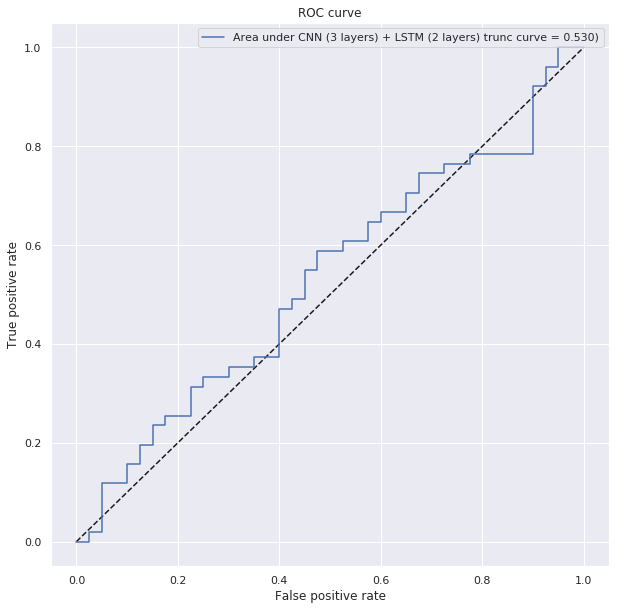

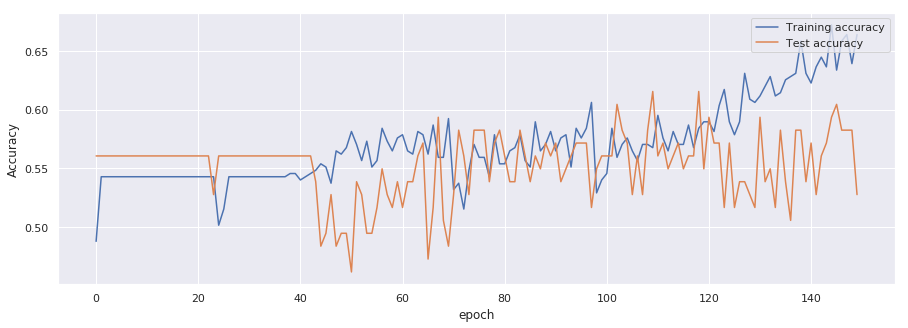

In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint

from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten

# X TRAIN -> (instance, features, data)

load_model = False

X_train = X_TRAIN_trunc[:,0,:].reshape((X_TRAIN_trunc.shape[0], X_TRAIN_trunc.shape[2], 1))
print('Input training data shape:', X_train.shape)
X_test = X_TEST_trunc[:,0,:].reshape((X_TEST_trunc.shape[0], X_TEST_trunc.shape[2], 1))
print('Test data shape:', X_test.shape)
y_train, y_test = y_TRAIN, y_TEST


epochs, batch_size = 150, 32
filters = 8


model10 = Sequential()

# conv layer 1
model10.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu', 
                  input_shape=(X_train.shape[1],X_train.shape[2])))
model10.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 2
model10.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model10.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 3
model10.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model10.add(MaxPooling1D(pool_size=2)) #reduced data size

#LSTM layer(s)
units1, units2 = 100, 20
model10.add(LSTM(units1, return_sequences=True))
model10.add(Dropout(0.2)) # should help in avoiding overfitting
model10.add(LSTM(units2))

#output layer
model10.add(Dense(1, activation='sigmoid'))

print(model10.summary())

# load best model if demanded and is present
if load_model==True & len(glob.glob('CNN_3Layer_LSTM_2Layer_*trunc.best.hdf5'))!=0:      
    # load the best checkpoint weights
    model10.load_weights(glob.glob('CNN_3Layer_LSTM_2Layer_*trunc.best.hdf5')[0])
    # Compile model (required to make predictions)
    model10.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print('********Pre-existing best model was loaded*******')
else:
    print('********No Weights file present. EXITING*******')
    print('-----------------------------------------------')
    print('**************Fitting new model************')

    # checkpoint the best model
    file='CNN_3Layer_LSTM_2Layer_{}Units+{}Units_trunc.best.hdf5'.format(units1, units2)
    checkpoint = ModelCheckpoint(file, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    model10.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history10=model10.fit(X_train, y_train, 
                          epochs=epochs, 
                          batch_size=batch_size,
                          validation_data=(X_test, y_test),
                          callbacks=callbacks_list
                          )

# get ROC curve for the model
from sklearn.metrics import roc_curve, auc
# ------------get ROC curve for the model
y_test_pred = model10.predict(X_test).ravel()
fpr_C3L2_trunc, tpr_C3L2_trunc, thresholds_C3L2_trunc = roc_curve(y_test, y_test_pred)
auc_C3L2_trunc = auc(fpr_C3L2_trunc, tpr_C3L2_trunc)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_C3L2_trunc, tpr_C3L2_trunc, label='Area under CNN (3 layers) + LSTM (2 layers) trunc curve = {:.3f})'.format(auc_C3L2_trunc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

if load_model==False:
    # accuracy history
    fig, ax = plt.subplots(figsize=(15,5))
    plt.plot(history10.history['acc'], label='Training accuracy')
    plt.plot(history10.history['val_acc'], label='Test accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')



plt.show()